In [ ]:
# 12-18-2022
# benjamin m hardy
# Purpose: demonstrate relationships dictating relative noise contributions from 
# some key references:

# great intro reference is Noise in MRI - Al macovski
# [1] https://pubmed.ncbi.nlm.nih.gov/8875425/
# another more recent interesting take:
# [2] https://ieeexplore.ieee.org/document/5910383

# great description of Q-relationship:
# [3] https://pubmed.ncbi.nlm.nih.gov/10680678/
# would be good to improve on this paper's assumptions and to show it experimentally.

# Overall great reference is Darasse and Ginefri
# [4] https://pubmed.ncbi.nlm.nih.gov/14652180/

# key question: How does temperature, coil size, conductivity of sample, influence noise contributions
# figure 4 in Darasse and Ginefri is the experimental demonstration we would want to show.
# surface loop - solenoid, since resistance of coil is added with turns.
# could mean that solenoids occurs at larger radius where sample doesn't matter as much.

# Motivation could be SNR gain due to cooling, and what size coil to make given this change.
# How to maximize SNR gain due to cooling with fill-factor and change of the coil size.

# sample driven, so you have a sample size, need to decide coil size, to maximize cooling?
# point of paper:
#
# 1. easy guide to determine what size coil maximizes influence of cooling on SNR
# 2. Demonstrating my cryogenic cooling of tune and match circuit with experimental proof of the above


In [81]:
# imports:
from math import pi
import numpy as np
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

In [77]:
# See Dr. Gore's notes for most of these equations...
#
# is there a situation where size needs to be optimized?
# reference 2 seems to agree.

# practically, you can't control temperature or sample size, fix temperatures and sample sizes
# make class to combine all this
class coil_sample_experiment():
    def __init__(self, r,I,z,b,rho_s,f0,n,rho_c,wd,ts,tc):
        self.r = r # coil radius m
        self.I = I # current in conductor, usually 1 A
        self.z = z # depth from center of coil to sample
        self.b = b # sample radius, assumes spherical sample (m)
        self.rho_s = rho_s # sample resistivity, usually 2 (Ohm m)
        self.omega = 2*pi*f0 # rad Hz
        # other coil stuff
        self.n = n # number of turns
        self.rho_c = rho_c # coil resistivity, 1.68e-8 ohm m at room temp
        self.wd = wd # wire diameter, (m)
        # copper: mu/munot = 0.999994
        self.munot = 4*pi*1e-7 # H/m vacuum permeability of free-space
        self.mu = 0.999994*self.munot # copper specific rn
        self.ts = ts 
        self.tc = tc 
        
    def b1_axial(self):
        return (self.munot*self.r**2*self.I)/(2*(self.r**2 + self.z**2)**(3/2))

    def etaf(self):
        return self.b1_axial()/self.I

    def Rsample(self):
        eta = self.etaf() 
        return 2*pi*self.omega**2 *eta**2 * self.b**5 *(1/(self.rho_s*15)) # agrees with Dr. Gore's notes.

    # for coil:
    def Rcoil(self):
        le = 2*pi*self.r*self.n
        
        sd = self.skinDepth()
        A = 2*pi*self.wd*sd
        return rho_c*le/A

    def skinDepth(self):
        # source: https://www.microwaves101.com/calculators/869-skin-depth-calculator
        return (2*self.rho_c/(self.mu*self.omega))**(.5) # close enough to Gore notes

    # ratio of the two:
    def rRatio(self):
        rc = self.Rcoil()
        rs = self.Rsample()
        return rs/rc # good, confirmed by Gore's notes.
    
    def SNR(self):
        S = 1 # SNR normalized to 1
        snr = S/(np.sqrt(self.Rcoil()*self.tc + self.Rsample()*self.ts))
        return snr

In [132]:
# Gather DATA!
# Show how SNR varies with coil size, at two temps. with fixed sample radii (10 cm , 1cm, 1mm)
I = 1
# z depends on sample size always center of sample
rho_s = 2 # ohm m, .5 S/m conductivity
f0 = 650e6
n = 1 # surface loop for now
wd = .001 
ts = 293
tsCold = 273.7
# coil sizes:
coilSizes = np.linspace(.0005, .07, 1000) # .5mm -> 70 mm coil size

# sample size 1: sample is 10 cm
b = [.1, .01, .001] # 10 cm, 1cm, 1mm sample radius

# z = [.001,.001,.001]
#z = np.divide(b,10)
z = b

# temperature stuff
rho_c = 1.68e-8 # room temp
tc = 293

rho_cCold = 1.8e-09 #
tcCold = 70

snr1_rt = []
snr1_ct = []
snr2_rt = []
snr2_ct = []
snr3_rt = []
snr3_ct = []

for ri in coilSizes:
    # sample size 1:
    cse = coil_sample_experiment(ri,I,z[0],b[0],rho_s,f0,n,rho_c,wd,ts,tc)
    snr1_rt.append(cse.SNR())
    cse = coil_sample_experiment(ri,I,z[0],b[0],rho_s,f0,n,rho_cCold,wd,tsCold,tcCold)
    snr1_ct.append(cse.SNR())
    # sample size 2:
    cse = coil_sample_experiment(ri,I,z[1],b[1],rho_s,f0,n,rho_c,wd,ts,tc)
    snr2_rt.append(cse.SNR())
    cse = coil_sample_experiment(ri,I,z[1],b[1],rho_s,f0,n,rho_cCold,wd,tsCold,tcCold)
    snr2_ct.append(cse.SNR())
    # sample size 3:
    cse = coil_sample_experiment(ri,I,z[2],b[2],rho_s,f0,n,rho_c,wd,ts,tc)
    snr3_rt.append(cse.SNR())
    cse = coil_sample_experiment(ri,I,z[2],b[2],rho_s,f0,n,rho_cCold,wd,tsCold,tcCold)
    snr3_ct.append(cse.SNR())


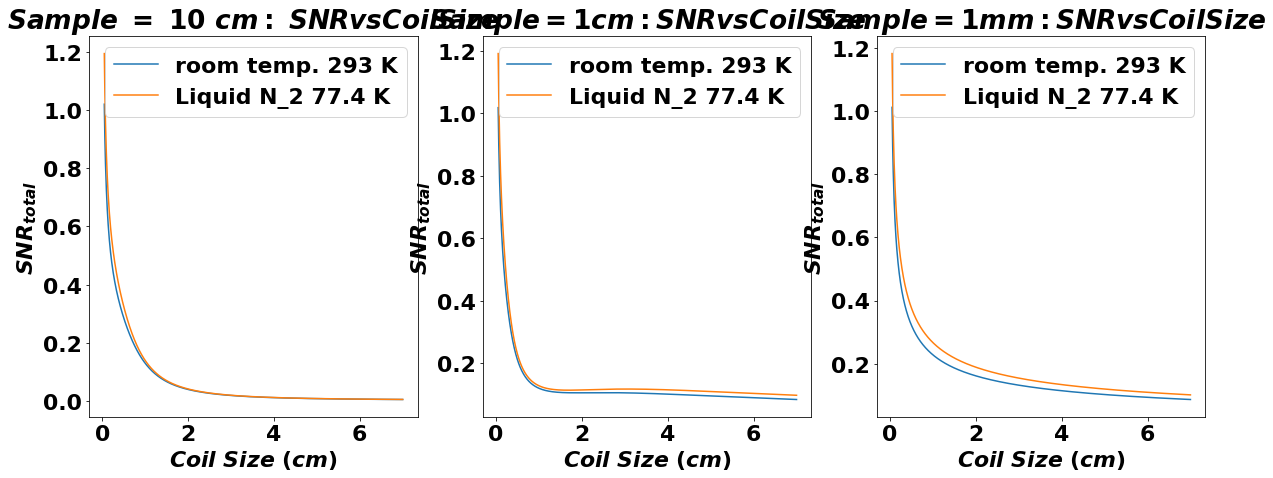

In [133]:
# plot it now:
plt.subplots(figsize=(20,7))
plt.subplot(1,3,1)
plt.plot(coilSizes*100, snr1_rt)
plt.plot(coilSizes*100, snr1_ct)

plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{total}$')
plt.title(r'$Sample\ =\ 10\ cm:\ SNR vs Coil Size$')
plt.legend(['room temp. 293 K', 'Liquid N_2 77.4 K'])

plt.subplot(1,3,2)
plt.plot(coilSizes*100, snr2_rt)
plt.plot(coilSizes*100, snr2_ct)

plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{total}$')
plt.title(r'$Sample = 1 cm: SNR vs Coil Size$')
plt.legend(['room temp. 293 K', 'Liquid N_2 77.4 K'])

plt.subplot(1,3,3)
plt.plot(coilSizes*100, snr3_rt)
plt.plot(coilSizes*100, snr3_ct)

plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{total}$')
plt.title(r'$Sample = 1 mm: SNR vs Coil Size$')
plt.legend(['room temp. 293 K', 'Liquid N_2 77.4 K'])
plt.show()

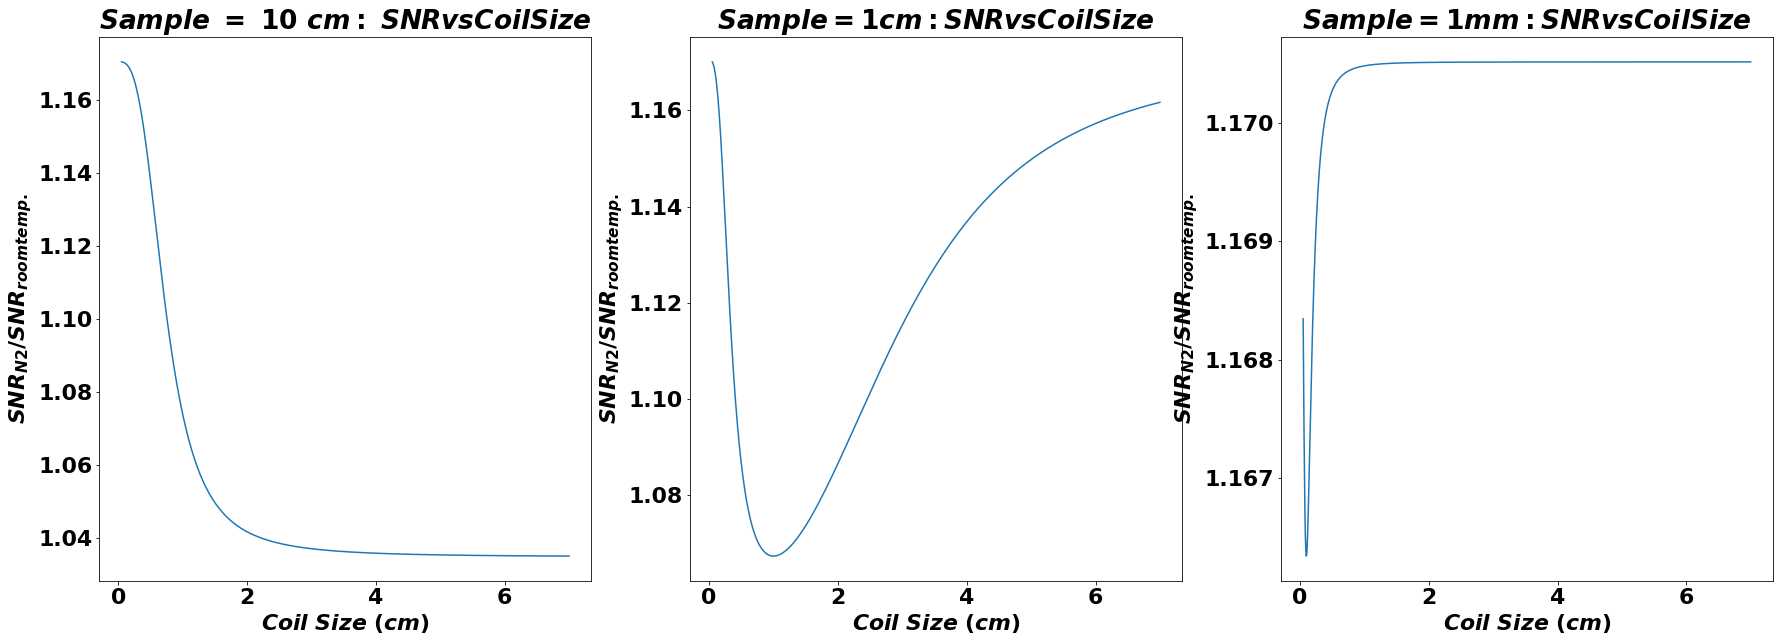

In [134]:
# plot it now:
plt.subplots(figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(coilSizes*100, np.divide(snr1_ct,snr1_rt))

plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{N2}/SNR_{room temp.}$')
plt.title(r'$Sample\ =\ 10\ cm:\ SNR vs Coil Size$')

plt.subplot(1,3,2)
plt.plot(coilSizes*100, np.divide(snr2_ct,snr2_rt))
plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{N2}/SNR_{room temp.}$')
plt.title(r'$Sample = 1 cm: SNR vs Coil Size$')

plt.subplot(1,3,3)
plt.plot(coilSizes*100, np.divide(snr3_ct,snr3_rt))

plt.xlabel('$Coil\ Size\ (cm)$')
plt.ylabel(r'$SNR_{N2}/SNR_{room temp.}$')
plt.title(r'$Sample = 1 mm: SNR vs Coil Size$')
plt.show()


In [ ]:
# this is interesting, because we are not considering the preamp or the tune and match
# this is simply the loop itself, telling that cooling the loop alone should only result in SNR changes of 20%

# Xin had an interesting point, sensitivity does change for coil size, so assuming its 1 doesn't work here.
#
#
# to do:
# 1. make sure resistivity values at 77.4 K are correct
# 2. choose a better z-value
# 3. Include resistance from preamp, and tune and match circuit (into the coil resistance?)
# 4. make Rsample heterogenous, or cylinder for solenoid?
# 
# questions: how does resistance of sample and coil change for a solenoid?